# Image Preprocessing and Extracting features from tables


# Steps:
1. Get the file location of the images
2. Summary statistics of the images if possible

## Getting file path and file name
* Using ubuntu terminal to cd into the folder with the images of that category and use ls -1
* ls -1 limit output to 1 column
* copy and paste file name to excel column
* put the file path to the folder and the cateogry in the 2nd and 3rd column
* Ctrl + Shift + C for copying from terminal

* Saved "images_file_name.csv" in the EDA_Preprocessing folder

# Visualize count

In [61]:
import pandas as pd
img = pd.read_csv('./img_filepath.csv')

FileNotFoundError: [Errno 2] File ./img_filepath.csv does not exist: './img_filepath.csv'

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
category = ['ants', 'chiggers', 'rash', 'negative', 'bed_bugs', 'spiders',
       'ticks']
count = [152,134,139,160,158,150,168]

img = pd.DataFrame({'category':category,'count':count})
img

,category,count
0,ants,152
1,chiggers,134
2,rash,139
3,negative,160
4,bed_bugs,158
5,spiders,150
6,ticks,168


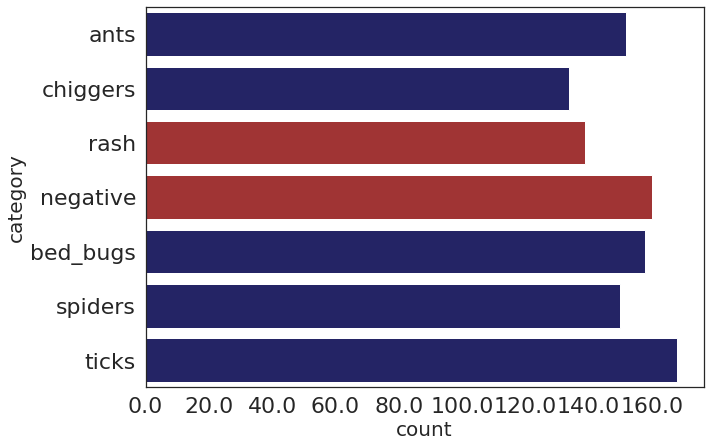

In [67]:
# this set the overall font size and image size
# style white has white background, no grid
sns.set(rc={'figure.figsize':(10,7),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

# setting the color palette to use
color_pal = {category: "firebrick" if category== "negative" or category == "rash" else "midnightblue" for category in img.category.unique()}

# if I want to set the palette
# sns.set_palette("pastel")

# making a countplot with my defined palette
f = sns.barplot(data=img, x='count',y='category', palette=color_pal)

# setting the xtick labels size
f.set_xticklabels(f.get_xticks(), size = 22)

# since y label is text, need to first get the text then set the font size of the text instead of the numbers
# getting the lables
_, ylabels = plt.yticks()
# setting the font size of the y tick text
f.set_yticklabels(ylabels, size=22)

plt.show()

In [63]:
# this set the overall font size and image size
# style white has white background, no grid
sns.set(rc={'figure.figsize':(10,7),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

# setting the color palette to use
color_pal = {category: "firebrick" if category== "negative" or category == "rash" else "midnightblue" for category in img.category.unique()}

# if I want to set the palette
# sns.set_palette("pastel")

# making a countplot with my defined palette
f = sns.countplot(data=img,y='category', palette=color_pal)

# setting the xtick labels size
f.set_xticklabels(f.get_xticks(), size = 22)

# since y label is text, need to first get the text then set the font size of the text instead of the numbers
# getting the lables
_, ylabels = plt.yticks()
# setting the font size of the y tick text
f.set_yticklabels(ylabels, size=22)

plt.show()

NameError: name 'img' is not defined

# Loading data as tf.data.Dataset
* https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
tf.__version__

'2.2.0'

In [16]:
import pathlib

data_dir = '/home/eyan/Desktop/bug_bite/web_scraping/useful/train'

data_dir = pathlib.Path(data_dir)

In [17]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

1188

In [18]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['ants', 'chiggers', 'rash', 'negative', 'bed_bugs', 'spiders',
       'ticks'], dtype='<U8')

In [19]:
BATCH_SIZE = 32
IMG_HEIGHT = 299
IMG_WIDTH = 299
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
  print(f.numpy())

b'/home/eyan/Desktop/bug_bite/web_scraping/useful/train/bed_bugs/bed_bugsimage87.jpg'
b'/home/eyan/Desktop/bug_bite/web_scraping/useful/train/negative/goose_bumpimage313.jpg'
b'/home/eyan/Desktop/bug_bite/web_scraping/useful/train/rash/rashimage10.jpg'
b'/home/eyan/Desktop/bug_bite/web_scraping/useful/train/ticks/ticksimage18.jpg'
b'/home/eyan/Desktop/bug_bite/web_scraping/useful/train/spiders/black_widowimage5.jpg'


In [21]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [22]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [23]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [24]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in labeled_ds.take(3):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  [False False False  True False False False]
Image shape:  (299, 299, 3)
Label:  [False False False False False  True False]
Image shape:  (299, 299, 3)
Label:  [ True False False False False False False]


# Getting ready for training

In [55]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [56]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [57]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

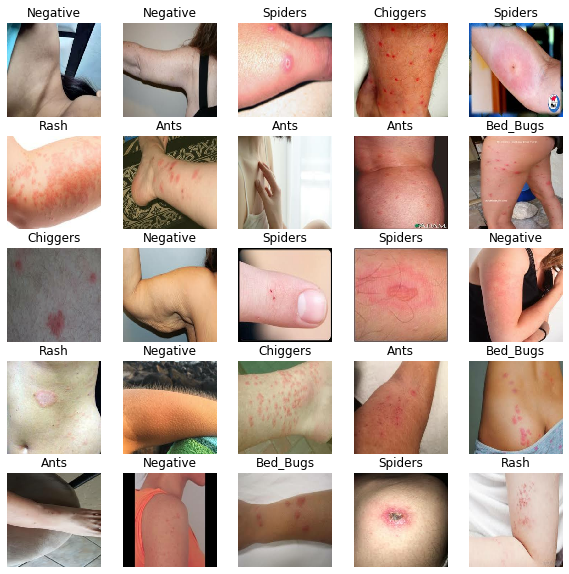

In [58]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [19]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 28.62792134284973 s
1117.78985 Images/s


In [20]:
print(train_ds)

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, 7)), types: (tf.float32, tf.bool)>


# Getting the Inception v3 model

In [9]:
# import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
pre_trained_model = InceptionV3(input_shape = (299,299,3), include_top =False, weights = 'imagenet')

In [11]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow import keras


# Flatten the output to 1 dimension
x = keras.layers.Flatten()(pre_trained_model.output)

x = keras.layers.Dense(1024,activation='relu')(x)

x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(7,activation='softmax')(x)

model = keras.Model(pre_trained_model.input,x)

model.compile(optimizer = RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['acc'])

In [13]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                  rotation_range =40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_dir = '/home/eyan/Desktop/bug_bite/web_scraping/useful/train'
validation_dir = '/home/eyan/Desktop/bug_bite/web_scraping/useful/validation'

train_generator = train_datagen.flow_from_directory(train_dir,batch_size=20,class_mode='categorical',target_size=(299,299))

validation_generator = test_datagen.flow_from_directory(validation_dir,batch_size=20,class_mode='categorical',target_size=(299,299))

Found 1191 images belonging to 7 classes.
Found 208 images belonging to 7 classes.


In [14]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=80,epochs=10,validation_steps=50,verbose=1,callbacks=[callbacks])

Epoch 1/10
80/80 [==============================] - 1056s 13s/step - loss: 6.5936 - acc: 0.2502 - val_loss: 1.7556 - val_acc: 0.3466
Epoch 2/10
80/80 [==============================] - 966s 12s/step - loss: 1.8555 - acc: 0.3457 - val_loss: 1.5489 - val_acc: 0.4362
Epoch 3/10
80/80 [==============================] - 961s 12s/step - loss: 1.6700 - acc: 0.4102 - val_loss: 1.5953 - val_acc: 0.4160
Epoch 4/10
80/80 [==============================] - 964s 12s/step - loss: 1.4789 - acc: 0.4551 - val_loss: 1.8183 - val_acc: 0.4191
Epoch 5/10
80/80 [==============================] - 959s 12s/step - loss: 1.4337 - acc: 0.5154 - val_loss: 1.5916 - val_acc: 0.4734
Epoch 6/10
80/80 [==============================] - 960s 12s/step - loss: 1.3729 - acc: 0.5209 - val_loss: 1.3832 - val_acc: 0.5347
Epoch 7/10
80/80 [==============================] - 965s 12s/step - loss: 1.2787 - acc: 0.5493 - val_loss: 1.3659 - val_acc: 0.5160
Epoch 8/10
80/80 [==============================] - 962s 12s/step - loss: 1